In [1]:
# jupyter extensions
%load_ext autoreload
%autoreload 2

In [35]:
from tqdm import tqdm

import jax.numpy as jnp
import jax
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

from src.wgan import WGAN
from src.data import NumpyLoader, FlattenAndCast


In [36]:
# Hyperparameters
batch_size = 64
epoch = 100 
seed = 42
generator_learning_rate=5e-4
critic_learning_rate=5e-4 
n_critic=5
clipping_value=1e-2
latent_space_dim=100


In [37]:
# dataset
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_data_loader = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)
data_dim = next(iter(training_data_loader))[0].shape[1]

In [38]:
wgan = WGAN(seed=seed, 
    generator_learning_rate=generator_learning_rate, 
    critic_learning_rate=critic_learning_rate,
    n_critic=n_critic,
    clipping_value=clipping_value,
    batch_size=batch_size,
    data_dim=data_dim,
    latent_space_dim=latent_space_dim)


In [27]:
from tqdm import tqdm
critic_loss = []
generator_loss = [] 
wasserstein_loss = []
for e in range(epoch):
    if e > 1: 
        wgan._n_critic = n_critic
    else: 
        wgan._n_critic = 100 # this trick is not in the paper but in the code
    with tqdm(enumerate(training_data_loader), desc=f"Epoch {e}") as pbar:
        for i, (x,y) in pbar:
            wgan._rng, sampling_rng = jax.random.split(wgan._rng)
            prior_data = jax.random.normal(sampling_rng, (wgan._batch_size, wgan._latent_space_dim))
            if i%wgan._n_critic == 0:
                wgan._learner_state, generator_logs = wgan.update_generator(wgan._learner_state, prior_data)
            else:
                wgan._learner_state, critics_logs = wgan.update_critic(wgan._learner_state, x, prior_data)
            
            if i%100==0: 
                pbar.set_postfix(critic_loss=critics_logs['real_loss'], generator_loss=-generator_logs['generated_loss'], wasserstein_loss=-critics_logs['loss'])
                critic_loss.append(critics_logs['real_loss'])
                generator_loss.append(-generator_logs['generated_loss'])
                wasserstein_loss.append(-critics_logs['loss'])


Epoch 0: 938it [00:05, 164.63it/s, critic_loss=-179.02805, generator_loss=5.9410715] 
Epoch 1: 938it [00:05, 171.16it/s, critic_loss=-169.60794, generator_loss=29.81625] 
Epoch 2: 938it [00:05, 165.47it/s, critic_loss=-93.90394, generator_loss=-38.210747]  
Epoch 3: 938it [00:05, 165.27it/s, critic_loss=-120.65593, generator_loss=-18.41704]  
Epoch 4: 938it [00:05, 164.30it/s, critic_loss=-120.45587, generator_loss=-16.970778] 
Epoch 5: 938it [00:05, 165.16it/s, critic_loss=-121.986115, generator_loss=5.5647955] 
Epoch 6: 938it [00:05, 164.71it/s, critic_loss=-117.2498, generator_loss=-19.686844]  
Epoch 7: 938it [00:05, 164.44it/s, critic_loss=-116.316025, generator_loss=-8.668297]  
Epoch 8: 938it [00:05, 164.33it/s, critic_loss=-119.787704, generator_loss=-18.57508]
Epoch 9: 938it [00:05, 164.53it/s, critic_loss=-123.5926, generator_loss=-6.784954]   
Epoch 10: 938it [00:05, 164.49it/s, critic_loss=-97.19949, generator_loss=-2.1551366]  
Epoch 11: 938it [00:05, 164.91it/s, critic_lo

KeyboardInterrupt: 

NameError: name 'wasserstein_loss' is not defined

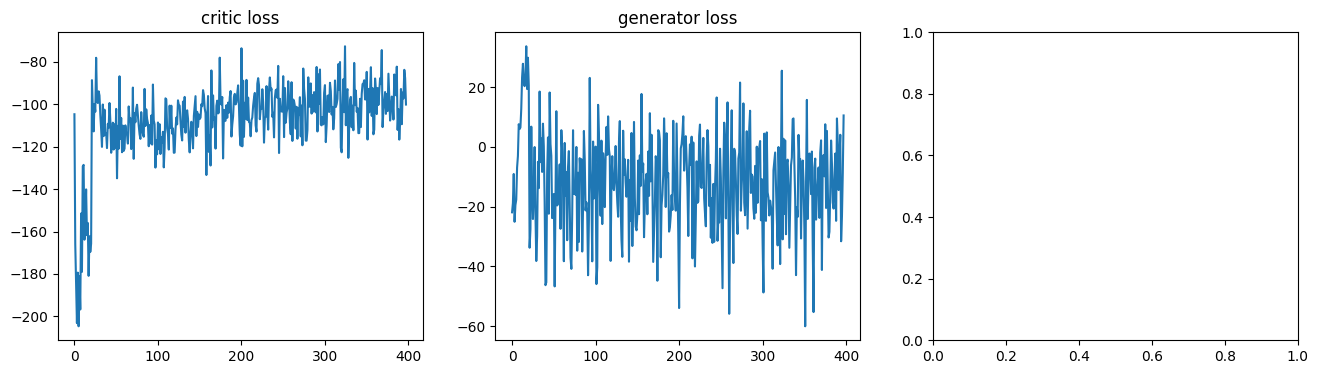

In [43]:
f, ax =plt.subplots(1,3, figsize=(16,4))

ax[0].plot(range(len(critic_loss)), critic_loss)
ax[0].set_title('critic loss')
ax[1].plot(range(len(critic_loss)), generator_loss)
ax[1].set_title('generator loss')
ax[0].plot(range(len(critic_loss)), wasserstein_loss)
ax[0].set_title('wasserstein loss')